In [1]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import stable_baselines3
#from conversion_bundle_EMS.parameters import parameter as PARAMS
from parameters import parameter as PARAMS
from fmi_mlc import fmi_gym, fmi_gym_parameter
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, ProgressBarCallback
from stable_baselines3 import A2C
from tqdm.auto import tqdm  # make sure `tqdm` is installed
import sys
import warnings

ModuleNotFoundError: No module named 'fmi_mlc'

In [ ]:
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
PARAMS

{'seed': 1,
 'store_data': True,
 'fmu_step_size': 600.0,
 'fmu_path': 'ResFlatdue_IDF_EMS_optimal_cleaned.fmu',
 'fmu_start_time': 0,
 'fmu_warmup_time': 259200,
 'fmu_final_time': 31536000,
 'action_names': ['Zona4_wall2_shade_FMU',
  'Zona2_wall2_shade_FMU',
  'Zona2_wall3_shade_FMU',
  'Zona1_wall2_shade_FMU',
  'Zona1_wall8_shade_FMU',
  'Zona1_wall9_shade_FMU'],
 'action_min': array([-1000., -1000., -1000., -1000., -1000., -1000.]),
 'action_max': array([1000., 1000., 1000., 1000., 1000., 1000.]),
 'observation_names': ['Tair_z1',
  'Tair_z2',
  'Tair_z3',
  'Tair_z4',
  'T_ext',
  'DNI',
  'DistrictHeating',
  'DistrictCooling',
  'Electricity',
  'ShadeStatus_Zone1_Wall2',
  'ShadeStatus_Zone1_Wall8',
  'ShadeStatus_Zone1_Wall9',
  'ShadeStatus_Zone2_Wall2',
  'ShadeStatus_Zone2_wall3',
  'ShadeStatus_Zone4_Wall2'],
 'reward_names': []}

In [ ]:
# Define the actions and observations to keep
my_observations = [
    'Tair_z1', 'Tair_z2', 'Tair_z4', 'T_ext', 'DNI', 'DistrictHeating', 
    'DistrictCooling', 'ShadeStatus_Zone1_Wall2', 'ShadeStatus_Zone1_Wall8',
    'ShadeStatus_Zone1_Wall9', 'ShadeStatus_Zone2_Wall2',
    'ShadeStatus_Zone2_wall3', 'ShadeStatus_Zone4_Wall2'
]
my_actions = [
    'Zona4_wall2_shade_FMU', 'Zona2_wall2_shade_FMU', 'Zona2_wall3_shade_FMU',
    'Zona1_wall2_shade_FMU', 'Zona1_wall8_shade_FMU', 'Zona1_wall9_shade_FMU'
]

# Apply filters
PARAMS["observation_names"] = [o for o in PARAMS["observation_names"] if o in my_observations]
PARAMS["action_names"] = [a for a in PARAMS["action_names"] if a in my_actions]

# Fix the action bounds for the new count
PARAMS["action_min"] = np.zeros(len(PARAMS["action_names"]))
PARAMS["action_max"] = np.ones(len(PARAMS["action_names"]))

In [ ]:
class ComfortEnergyPostProcessor:
    """
    Post-processor used in FMI-MLC for computing the reward related to shading devices.

    Final reward logic (updated minimal version):
        reward = -(comfort_pen + energy_pen) + solar_bonus

    Where:
        comfort_pen = sum over all Tin_* zones of (d)^2
        energy_pen = lambda_energy * (|DistrictHeating| + |DistrictCooling|)
        solar_bonus encourages leaving shading open in winter when Tin < Th and DNI is present

    NOTES:
    - Uses ONLY variables received from the FMU via From:Variable.
    - Comfort band thresholds Th/Tc are defined here (hardcoded).
    """

    def __init__(self, p):
        self.p = p

        # Comfort band limits (°C)
        self.Th = 19.0
        self.Tc = 24.0

        # Optional normalization factor for comfort deviation
        self.dT_tol = 1.0

        # Weight applied to the total energy consumption term
        self.lambda_energy = 1e-4

        # Minimal solar-gain incentive (tune small)
        self.lambda_solar = 1e-4

        # Debug flag (avoid printing every step in training)
        self.debug = False

    def do_calc(self, data, init):
        # ---------------------------------------------------------------------
        # 0) SAFETY CHECK
        # ---------------------------------------------------------------------
        if data is None or len(data) == 0:
            return data

        # ---------------------------------------------------------------------
        # 1) READ SOLAR RADIATION (DNI) - optional
        # ---------------------------------------------------------------------
        dni_val = float(data["DNI"].iloc[0]) if "DNI" in data.columns else 0.0

        # Optional gating (keep commented unless you really want it)
        # if dni_val < 1.0:
        #     data["reward"] = 0.0
        #     return data

        # ---------------------------------------------------------------------
        # 2) COMFORT PENALTY CALCULATION
        # ---------------------------------------------------------------------
        comfort_pen = 0.0

        tin_cols = [c for c in data.columns if c.startswith("Tair_")]

        for col in tin_cols:
            Tin = float(data[col].iloc[0])

            if Tin < self.Th:
                d = self.Th - Tin
            elif Tin > self.Tc:
                d = Tin - self.Tc
            else:
                d = 0.0

            comfort_pen += (d / self.dT_tol) ** 2

        # ---------------------------------------------------------------------
        # 3) HEATING/COOLING ENERGY PENALTY (final delivered energy)
        # ---------------------------------------------------------------------
        try:
            Eh = float(data["DistrictHeating"].iloc[0])  # [J]
            Ec = float(data["DistrictCooling"].iloc[0])  # [J]
        except KeyError as e:
            raise RuntimeError(f"Energy variable missing in the FMU: {e}")

        E_final = abs(Eh) + abs(Ec)
        energy_pen = self.lambda_energy * E_final

        # ---------------------------------------------------------------------
        # 4) MINIMAL SOLAR BONUS (helps winter shading)
        #    If zones are too cold and sun is present, reward solar gains slightly.
        # ---------------------------------------------------------------------
        solar_bonus = 0.0
        if dni_val > 1.0 and len(tin_cols) > 0:
            Tin_mean = sum(float(data[c].iloc[0]) for c in tin_cols) / len(tin_cols)
            if Tin_mean < self.Th:
                # Encourage benefiting from solar radiation when below comfort
                solar_bonus = self.lambda_solar * dni_val

        # ---------------------------------------------------------------------
        # 5) FINAL REWARD
        # ---------------------------------------------------------------------
        reward = - (comfort_pen + energy_pen) + solar_bonus
        data["reward"] = reward

        if self.debug:
            print(
                f"Comfort Penalty: {comfort_pen:.4f}, Final Energy: {E_final:.4f}, "
                f"Energy Penalty: {energy_pen:.4f}, Solar Bonus: {solar_bonus:.4f}, "
                f"Total Reward: {reward:.4f}"
            )

        return data


In [ ]:
PARAMS['postprocessor'] = ComfortEnergyPostProcessor

In [ ]:
class SB3Wrapper(gym.Wrapper):
    """
    SB3Wrapper around an existing fmi_gym environment.

    Semantics:

    - RL episode: fixed duration in hours (episode_hours, e.g. 48h).
    - Physical FMI episode: runs from the initial time up to fmu_final_time.
    - reset of fmi_mlc (env.reset()) is called ONLY when
      the physical simulation has finished (done_env == True).

    - If ONLY the RL episode ends (e.g. 2 days) but the physical simulation continues:
        * we return done=True to the agent (end of RL episode)
        * we DO NOT call env.reset()
        * the FMU continues from its current physical state
        * the next RL episode starts from the same observation (last_obs)
          and continues the same physical trajectory.

    - Action space:
        * SB3 sees MultiDiscrete([2] * N_shades)
        * 0 -> 0.0, 1 -> 7.0
        * N_shades = len(env.parameter["action_names"])
          (one discrete action per shading device)

    - Observation space: identical to that of the wrapped fmi_gym environment.
    """

    def __init__(self, env: fmi_gym, episode_hours: float = 48.0):
        # env is already a configured fmi_gym environment
        super().__init__(env)

        # Keep a direct alias for clarity
        self.base_env = env

        # ----- Action space: MultiDiscrete [0, 1] for each FMI action -----
        # We read the list of action names from the fmi_gym parameters
        self.action_names = self.base_env.parameter["action_names"]
        self.n_actions = len(self.action_names)

        # Each action can be 0 or 1; SB3 sees this as a MultiDiscrete space
        self.action_space = spaces.MultiDiscrete([2] * self.n_actions)

        # ----- Observation space: identical to FMI-MLC / fmi_gym -----
        self.observation_space = self.base_env.observation_space

        # ----- RL episodes: duration expressed in number of steps -----
        self.episode_hours = episode_hours
        self.dt = self.base_env.parameter["fmu_step_size"]  # [s] FMU time step

        # Compute maximum number of RL steps per episode:
        # episode_hours [h] → seconds, then divide by FMU step size dt [s].
        self.max_steps_per_episode = int(
            (self.episode_hours * 3600.0) / self.dt
        )

        # Internal wrapper state
        self.rl_steps = 0          # number of RL steps in the current episode
        self.env_done = False      # True if fmi_gym reported end of physical simulation
        self.last_obs = None       # last observation returned to the agent

    # ------------------------------------------------------------------
    # RESET
    # ------------------------------------------------------------------
    def reset(self, **kwargs):
        """
        Reset from the agent's point of view (RL episode reset).

        Behavior:

        - If the physical simulation is NOT finished (env_done == False):
             -> DO NOT call env.reset()
             -> DO NOT touch the FMU state
             -> only reset the RL step counter and
                return the last observation (last_obs).
                This starts a new RL episode over the same physical trajectory.

        - If the physical simulation IS finished (env_done == True):
             -> call env.reset() ONCE (true FMU reset)
             -> reset env_done and rl_steps
             -> return the new initial observation from the environment.

        Notes:
        - On the VERY first call, last_obs is None, so we must reset the base
          environment to obtain the initial observation.
        """

        # Case 1: very first reset call, no previous observation exists yet
        if self.last_obs is None:
            obs = self.base_env.reset()
            self.rl_steps = 0
            self.env_done = False
            self.last_obs = obs
            return obs

        # Case 2: physical simulation NOT finished -> logical RL reset only
        if not self.env_done:
            # Do not touch the FMU: the new RL episode starts from the last
            # physical state and observation already computed.
            self.rl_steps = 0
            return self.last_obs

        # Case 3: physical simulation FINISHED -> true FMI-MLC reset
        obs = self.base_env.reset()
        self.rl_steps = 0
        self.env_done = False
        self.last_obs = obs
        return obs

    # ------------------------------------------------------------------
    # STEP
    # ------------------------------------------------------------------
    def step(self, action):
        """
        RL step wrapper.

        - action: MultiDiscrete[0..1]^N_shades as seen by SB3.

        - Mapping from SB3 discrete action to FMU continuous action:
              0 -> 0.0
              1 -> 7.0
          applied element-wise to each shading device/action.

        - The mapped action is passed to fmi_gym.step().

        - Internal counters:
            * rl_steps is incremented every time step() is called.
            * env_done stores whether the underlying physical simulation has ended.

        - done_rl (the 'done' returned to SB3) is True if:
            * we reached the RL episode duration in steps
              (rl_steps >= max_steps_per_episode), OR
            * the physical simulation (fmi_gym) signaled done_env == True.

          In the first case only (RL episode ends but env_done == False),
          the FMU continues from its current state and the next reset()
          will just restart the RL episode logically from last_obs.
        """

        # Convert the MultiDiscrete action into a NumPy array of ints
        action = np.asarray(action, dtype=int)

        # Map discrete {0, 1} actions to continuous {0.0, 7.0} values for the FMU
        fmi_action = np.where(action == 0, 0.0, 7.0)

        # Delegate the step to the underlying fmi_gym environment
        obs, reward, done_env, info = self.base_env.step(fmi_action)

        # Update internal state with the latest observation and physical done flag
        self.last_obs = obs
        self.env_done = bool(done_env)

        # Increase RL step counter for the current RL episode
        self.rl_steps += 1

        # RL episode termination:
        # - either we reached the maximum number of steps for this episode
        # - or the underlying physical simulation has ended
        done_rl = (self.rl_steps >= self.max_steps_per_episode) or self.env_done

        # Return the observation, reward, RL done flag, and info dict
        return obs, reward, done_rl, info

In [ ]:
class EpisodeStatsCallback(BaseCallback):
    """
    Custom callback to collect per-episode statistics during training with Stable-Baselines3.

    What it stores:
    - episode_returns : list of total rewards per episode (sum of step rewards)
    - episode_lengths : list of episode lengths in number of environment steps
    - episode_metrics : list of dicts, each containing ALL logged train/* metrics
                        at the end of each episode (e.g., losses, entropy, etc.)

    Notes:
    - Works with both single and vectorized environments (n_envs >= 1).
    - For vectorized envs, it tracks cumulative returns and lengths separately
      for each environment index.
    """

    def __init__(self, verbose=0):
        """
        Constructor.

        :param verbose: verbosity level (0 = silent, >0 prints episode summaries).
        """
        super().__init__(verbose)

        # Total return (sum of rewards) per completed episode
        self.episode_returns = []

        # Length in steps per completed episode
        self.episode_lengths = []

        # Here we store ALL metrics logged by the SB3 logger (only train/*),
        # one dict per completed episode.
        self.episode_metrics = []  # <--- here we store ALL metrics

    def _on_training_start(self):
        """
        Called once at the beginning of training.

        Initializes per-environment accumulators:
        - _ep_ret: cumulative reward for the current ongoing episode in each env
        - _ep_len: number of steps taken in the current ongoing episode in each env
        """
        # Number of parallel environments (1 for non-vectorized envs)
        n_envs = getattr(self.training_env, "num_envs", 1)

        # Cumulative reward per environment (current episode)
        self._ep_ret = np.zeros(n_envs)

        # Number of steps per environment (current episode)
        self._ep_len = np.zeros(n_envs, dtype=int)

    def _on_step(self):
        """
        Called at every environment step.

        Responsibilities:
        - Read rewards and done flags for each environment.
        - Accumulate episode return and length for each env index.
        - When an episode ends (done=True for that env):
            * store total return and length in the public lists
            * extract ALL train/* metrics from the SB3 logger
              and store them in episode_metrics
            * optionally print a summary if verbose > 0
            * reset per-episode accumulators for that env index
        """

        # Get rewards and done flags from the locals dict.
        # SB3 can use either "rewards"/"dones" or "reward"/"done"
        rewards = np.atleast_1d(self.locals.get("rewards", self.locals.get("reward")))
        dones   = np.atleast_1d(self.locals.get("dones",   self.locals.get("done")))

        # Iterate over each environment in the vectorized setup
        for i, (r, d) in enumerate(zip(rewards, dones)):
            # Accumulate reward and step count for the current episode of env i
            self._ep_ret[i] += float(r)
            self._ep_len[i] += 1

            # If the environment signals the end of an episode
            if d:
                # Final return and length for the completed episode in env i
                R = float(self._ep_ret[i])
                L = int(self._ep_len[i])

                # Store episode-level stats
                self.episode_returns.append(R)
                self.episode_lengths.append(L)

                # Access all logged metrics from the SB3 logger
                metrics = self.model.logger.name_to_value

                # Extract ALL metrics whose key starts with "train/"
                # and strip the "train/" prefix from the keys.
                ep_m = {
                    k.replace("train/", ""): v
                    for k, v in metrics.items()
                    if k.startswith("train/")
                }
                self.episode_metrics.append(ep_m)

                # Optional console output
                if self.verbose:
                    print(
                        f"[Episode {len(self.episode_returns)}] "
                        f"R={R:.2f}, len={L}, metrics={ep_m}"
                    )

                # Reset accumulators for this environment index
                self._ep_ret[i] = 0.0
                self._ep_len[i] = 0

        # Returning True tells SB3 to continue training
        return True

In [ ]:
class TqdmProgressCallback(BaseCallback):
    """
    Callback that displays a live tqdm progress bar during SB3 training.

    Purpose:
    --------
    Stable-Baselines3 normally prints periodic logs, but does not provide
    a continuous progress bar. This callback fills that gap by showing a
    clean tqdm progress bar that updates in-place without producing new lines.

    How it works:
    -------------
    - At the beginning of training, a tqdm bar is created with `total_timesteps`.
    - At every call to `_on_step()`, we compute how many timesteps have passed
      since the last update and increment the bar by that delta.
      (This avoids unnecessary redraws and prevents line flooding.)
    - At the end of training, the bar is forced to completion and closed.

    Notes:
    ------
    - Uses `sys.stdout` to ensure correct behavior inside Jupyter notebooks
      and terminal environments.
    - `leave=False` ensures the bar disappears after completion rather than
      leaving a residual printed line.
    """

    def __init__(self, total_timesteps):
        """
        :param total_timesteps: the total number of agent training timesteps,
                                typically the same value passed to model.learn().
        """
        super().__init__()
        self.total_timesteps = total_timesteps
        self.pbar = None       # tqdm progress bar object
        self._last = 0         # last timestep count used to compute incremental updates

    def _on_training_start(self):
        """
        Called once at the beginning of training.

        Initializes the tqdm progress bar. The bar dynamically adapts its width
        to the terminal/notebook and updates smoothly without extra lines.
        """
        self.pbar = tqdm(
            total=self.total_timesteps,
            desc="Training",
            leave=False,          # do not leave a new line after completion
            file=sys.stdout,      # ensures proper display in notebook and terminal
            mininterval=0.1,      # minimum time between updates
            dynamic_ncols=True,   # adjust to terminal width
        )

    def _on_step(self):
        """
        Called at every environment step.

        We update the progress bar ONLY by the number of newly completed
        timesteps, to avoid unnecessary redraws.

        SB3 provides `self.num_timesteps`, which is the global count of steps
        since training started. We store the previous value in `self._last` to
        compute the delta.
        """
        delta = self.num_timesteps - self._last

        if delta > 0:
            self.pbar.update(delta)
            self._last = self.num_timesteps

        return True  # continue training

    def _on_training_end(self):
        """
        Called once at the end of training.

        Ensures the progress bar reaches 100% and then closes it cleanly.
        """
        # Force completion if not already full
        self.pbar.update(self.total_timesteps - self._last)
        self.pbar.close()

In [ ]:
# 1) FMI-MLC parameters
#    Here we configure the FMU simulation time window and behavior.

# Summer simulation period
PARAMS["fmu_start_time"] = 185 * 24 * 3600   # day 185 (July)
PARAMS["fmu_final_time"] = 220 * 24 * 3600   # day 220 (August)

# If False: the physical simulation is allowed to reset between episodes
# (this can interact with ignore_reset logic inside your fmi_gym / FMU wrapper).
PARAMS["ignore_reset"] = False               # physical simulation does NOT continue between episodes unconditionally

# FMU log level (0 = silent / minimal logging, higher = more verbose)
PARAMS["fmu-loglevel"] = 0

# 2) Create base FMI-MLC environment
#    fmi_gym is assumed to be a custom gym.Env that wraps the FMU.
base_env = fmi_gym(parameter=PARAMS)

# 3) Wrap with SB3Wrapper to:
#    - expose a MultiDiscrete action space for the blinds/shades
#    - handle RL episode length vs physical simulation length
env = SB3Wrapper(base_env)

In [ ]:
model = A2C(
    "MlpPolicy",
    env,
    gamma=0.997
)
total_timesteps = 250_000

In [ ]:
metrics_cb = EpisodeStatsCallback(verbose=0)
progress_cb = TqdmProgressCallback(total_timesteps=total_timesteps)
callback = CallbackList([progress_cb, metrics_cb])

# Train the RL agent on summer period
model.learn(
    total_timesteps=total_timesteps,
    callback=callback,
    progress_bar=False,  # DISATTIVA la barra interna SB3
)

Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33581.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33581.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp43yanmtk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

The IDF version of the input file ///tmp/JModelica.org/jm_tmp43yanmtk//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 11:57
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34779.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34779.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Number of outputs in ExternalInterface = 33
Number of inputs  in ExternalInterface = 14
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Training:   1%|          | 5051/500000 [00:52<30:05:13,  4.57it/s]

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:   2%|▏         | 7917/500000 [01:15<1:03:01, 130.13it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   2%|▏         | 10076/500000 [01:33<1:10:43, 115.46it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53239.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53239.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.37sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpovfftr0u//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 11:59
Initializing Response Factors
Calculating CTFs for "P

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpovfftr0u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:   3%|▎         | 12960/500000 [02:06<1:10:13, 115.59it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   3%|▎         | 15119/500000 [02:24<1:10:04, 115.34it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.13sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmplrv1cekp//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:00
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34563.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34563.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplrv1cekp//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:   4%|▎         | 17996/500000 [02:57<1:04:04, 125.36it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   4%|▍         | 20148/500000 [03:16<1:06:19, 120.57it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.83sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38277.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38277.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzlj_flb1//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:01
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzlj_flb1//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:   5%|▍         | 23035/500000 [03:49<1:04:12, 123.79it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   5%|▌         | 25195/500000 [04:08<1:17:18, 102.36it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.17sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.62sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1ocv17kc//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:02
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59647.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59647.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1ocv17kc//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:   6%|▌         | 28071/500000 [04:42<1:06:47, 117.75it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   6%|▌         | 30232/500000 [05:01<1:06:23, 117.93it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35657.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35657.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.01sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpl6dvn31e//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:03
Initializing Response Factors
Calculating CTFs for "P

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpl6dvn31e//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:   7%|▋         | 33113/500000 [05:33<1:07:32, 115.22it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   7%|▋         | 35269/500000 [05:51<1:11:06, 108.92it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.37sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpln0j2kge//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:03
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 32885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 32885.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpln0j2kge//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:   8%|▊         | 38158/500000 [06:23<1:02:20, 123.47it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   8%|▊         | 40318/500000 [06:41<1:08:37, 111.65it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.56sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpelapi80o//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:04
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpelapi80o//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:   9%|▊         | 43191/500000 [07:12<1:06:13, 114.95it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:   9%|▉         | 45351/500000 [07:30<1:02:02, 122.13it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.33sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.16sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpe0bssh3n//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:05
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48599.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48599.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpe0bssh3n//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  10%|▉         | 48237/500000 [08:02<1:00:56, 123.55it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  10%|█         | 50391/500000 [08:20<59:15, 126.46it/s]  Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.99sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53815.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53815.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpwx5ym1sj//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:06
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39263.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39263.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.08sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpw2qk6uoz//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:07
Initializing Response Factors
Calculating CTFs for "P

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpw2qk6uoz//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  12%|█▏        | 58316/500000 [09:44<1:13:14, 100.52it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  12%|█▏        | 60474/500000 [10:03<1:10:16, 104.23it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.58sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpa8b800ow//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:08
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58531.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58531.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpa8b800ow//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  13%|█▎        | 63358/500000 [10:42<1:10:25, 103.33it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  13%|█▎        | 65519/500000 [11:03<1:15:24, 96.02it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 53.28sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpeg7di95c//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:09
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47869.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47869.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpeg7di95c//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  14%|█▎        | 68394/500000 [11:38<59:17, 121.31it/s]  Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  14%|█▍        | 70549/500000 [11:56<56:30, 126.67it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.26sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpldf57q07//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:09
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44159.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44159.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpldf57q07//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  15%|█▍        | 73436/500000 [12:30<1:00:45, 117.00it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  15%|█▌        | 75596/500000 [12:49<58:53, 120.11it/s]  Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44185.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44185.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.44sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmphhfj8qq3//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:10
Initializing Response Factors
Calculating CTFs for "P

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmphhfj8qq3//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  16%|█▌        | 78471/500000 [13:22<57:28, 122.24it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  16%|█▌        | 80635/500000 [13:39<55:55, 124.97it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.65sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmplnz31m0d//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:11
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 43697.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 43697.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplnz31m0d//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  17%|█▋        | 83512/500000 [14:11<1:11:19, 97.32it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  17%|█▋        | 85667/500000 [14:28<54:32, 126.62it/s]  

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.47sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4hiruxua//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:12

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49595.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49595.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp4hiruxua//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  18%|█▊        | 88551/500000 [15:02<57:54, 118.41it/s]  Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  18%|█▊        | 90711/500000 [15:20<55:28, 122.97it/s]  

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.98sec
Reading input and weather file for preprocessor program.


INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpm9m61kup//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:13
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.03sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1bf26flb//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:14
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45037.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45037.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1bf26flb//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52743.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52743.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.62sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpmhdtro3k//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:15
Initializing Response Factors
Calculating CTFs for "P

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpmhdtro3k//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  21%|██        | 103666/500000 [17:32<58:31, 112.87it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  21%|██        | 105836/500000 [17:50<53:40, 122.40it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.15sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.64sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34267.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34267.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpuebwc2kg//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

The IDF version of the input file ///tmp/JModelica.org/jm_tmpuebwc2kg//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:15
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56495.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56495.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmphzwyu1cy//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:16
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmphzwyu1cy//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  23%|██▎       | 113755/500000 [19:13<53:42, 119.86it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  23%|██▎       | 115919/500000 [19:31<1:05:32, 97.68it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.91sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpbb2yie8k//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:17
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59567.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59567.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpbb2yie8k//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  24%|██▍       | 118786/500000 [20:03<53:35, 118.54it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  24%|██▍       | 120950/500000 [20:21<1:14:37, 84.65it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.85sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpbc4pvyuh//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:18
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpbc4pvyuh//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  25%|██▍       | 123831/500000 [20:54<55:39, 112.65it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  25%|██▌       | 125999/500000 [21:12<53:35, 116.30it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.18sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



The IDF version of the input file ///tmp/JModelica.org/jm_tmp5t5wnmak//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:19
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58005.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58005.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp5t5wnmak//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  26%|██▌       | 128875/500000 [21:44<54:25, 113.65it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  26%|██▌       | 131032/500000 [22:01<58:04, 105.88it/s] Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.99sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp6gs3gqc4//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:20
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44909.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp6gs3gqc4//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  27%|██▋       | 133913/500000 [22:34<53:06, 114.90it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  27%|██▋       | 136077/500000 [22:52<51:43, 117.28it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.20sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp8lbmggia//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was le

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59983.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59983.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

lations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=0

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp8lbmggia//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Number of outputs in ExternalInterface = 33
Number of inputs  in ExternalInterface = 14
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Training:  28%|██▊       | 138955/500000 [23:26<59:10, 101.70it/s] Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  28%|██▊       | 141114/500000 [23:43<57:06, 104.73it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.84sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_0ncj0ge//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:21
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37465.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37465.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_0ncj0ge//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  29%|██▉       | 143986/500000 [24:15<48:36, 122.06it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  29%|██▉       | 146151/500000 [24:33<47:57, 122.97it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.20sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpud75pgoe//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:22
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45895.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45895.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpud75pgoe//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  30%|██▉       | 149038/500000 [25:04<52:20, 111.77it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  30%|███       | 151193/500000 [25:22<48:52, 118.93it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.64sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpue9l13wd//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:23
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57901.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57901.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpue9l13wd//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  31%|███       | 154072/500000 [25:54<50:16, 114.69it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  31%|███       | 156238/500000 [26:11<47:12, 121.37it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.95sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpx20b2d8m//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:24

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60245.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60245.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpx20b2d8m//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  32%|███▏      | 159116/500000 [26:43<47:17, 120.12it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  32%|███▏      | 161267/500000 [27:01<47:06, 119.86it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.85sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp3bh4heok//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:25
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49765.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49765.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp3bh4heok//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  33%|███▎      | 164157/500000 [27:32<49:49, 112.33it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  33%|███▎      | 166313/500000 [27:50<44:21, 125.39it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.89sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpsq7zttid//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:25

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57353.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57353.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpsq7zttid//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  34%|███▍      | 169197/500000 [28:21<42:51, 128.62it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  34%|███▍      | 171349/500000 [28:38<43:03, 127.22it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.00sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1xz_mzpk//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:26
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47695.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47695.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1xz_mzpk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  35%|███▍      | 174226/500000 [29:09<40:50, 132.96it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  35%|███▌      | 176393/500000 [29:27<39:52, 135.26it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.94sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpi50pw614//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:27

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59735.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59735.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpi50pw614//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  36%|███▌      | 179275/500000 [29:59<40:57, 130.52it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  36%|███▋      | 181436/500000 [30:17<40:47, 130.13it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.27sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpoiihux2x//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:28
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60247.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60247.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpoiihux2x//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  37%|███▋      | 184307/500000 [30:50<50:33, 104.08it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  37%|███▋      | 186472/500000 [31:08<38:41, 135.08it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.42sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.46sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0jjypx8t//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.023
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:29
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0jjypx8t//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  38%|███▊      | 189348/500000 [31:42<50:07, 103.31it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  38%|███▊      | 191511/500000 [32:02<58:05, 88.50it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.74sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp1vs131a2//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:30
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53081.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53081.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp1vs131a2//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  39%|███▉      | 194395/500000 [32:36<48:46, 104.43it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  39%|███▉      | 196550/500000 [32:57<45:06, 112.12it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.89sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp27ka477i//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:30
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50375.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50375.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp27ka477i//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.79sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpib0m6n80//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:31
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34713.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34713.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpib0m6n80//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  41%|████      | 204466/500000 [34:22<49:35, 99.32it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  41%|████▏     | 206626/500000 [34:40<37:09, 131.60it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.26sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37801.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37801.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprm0yx52y//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:32
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  42%|████▏     | 209511/500000 [35:13<49:10, 98.45it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  42%|████▏     | 211670/500000 [35:33<41:32, 115.66it/s] 

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.14sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.01sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpifuriw3_//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:33

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46161.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46161.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpifuriw3_//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  43%|████▎     | 214546/500000 [36:06<37:36, 126.50it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  43%|████▎     | 216711/500000 [36:22<37:58, 124.32it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.03sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpf8mug_xx//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:34
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54345.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54345.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpf8mug_xx//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  44%|████▍     | 219588/500000 [36:51<34:51, 134.04it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  44%|████▍     | 221756/500000 [37:10<38:17, 121.13it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.66sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4oc3of6e//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:35
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52311.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52311.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp4oc3of6e//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  45%|████▍     | 224626/500000 [37:41<36:40, 125.14it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  45%|████▌     | 226795/500000 [38:01<42:37, 106.83it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48911.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48911.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.29sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.70sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpkccr8bef//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:36
Initializing Response Factors
Calculating CTFs for "P

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  46%|████▌     | 229668/500000 [38:35<41:32, 108.47it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  46%|████▋     | 231832/500000 [38:54<37:02, 120.64it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.57sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpc6yputo6//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:36
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 38947.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 38947.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpc6yputo6//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  47%|████▋     | 234706/500000 [39:26<34:31, 128.08it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  47%|████▋     | 236867/500000 [39:42<33:10, 132.19it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 40.93sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpdt22w0br//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:37
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48323.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48323.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpdt22w0br//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  48%|████▊     | 239746/500000 [40:11<34:08, 127.03it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  48%|████▊     | 241917/500000 [40:28<31:21, 137.18it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 39.86sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzfaq1knr//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:38
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 34655.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 34655.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzfaq1knr//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  49%|████▉     | 244788/500000 [40:59<35:01, 121.42it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  49%|████▉     | 246959/500000 [41:17<35:07, 120.06it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.61sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60253.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60253.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpxv0eq6v6//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:39
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpxv0eq6v6//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  50%|████▉     | 249838/500000 [41:48<33:32, 124.31it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  50%|█████     | 251992/500000 [42:05<35:29, 116.44it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.82sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmplqp17y10//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:40
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33219.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33219.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplqp17y10//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  51%|█████     | 254874/500000 [42:43<46:03, 88.70it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  51%|█████▏    | 257037/500000 [42:59<30:49, 131.36it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.12sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpq_lv93vz//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:41
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51991.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51991.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpq_lv93vz//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  52%|█████▏    | 259906/500000 [43:31<32:28, 123.25it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  52%|█████▏    | 262072/500000 [43:49<35:38, 111.25it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.89sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpaei1y0oo//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:41
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57559.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57559.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpaei1y0oo//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  53%|█████▎    | 264953/500000 [44:21<33:39, 116.38it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  53%|█████▎    | 267107/500000 [44:38<33:18, 116.55it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.13sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpn1u57xye//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was le

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58691.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58691.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpn1u57xye//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  54%|█████▍    | 269998/500000 [45:09<28:27, 134.72it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  54%|█████▍    | 272156/500000 [45:28<30:36, 124.08it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.50sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmph_sl24mr//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:43
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55515.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55515.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmph_sl24mr//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 44.85sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0xb2dt86//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:44

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0xb2dt86//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  56%|█████▌    | 280077/500000 [46:52<28:43, 127.63it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  56%|█████▋    | 282232/500000 [47:09<27:43, 130.88it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.53sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpukm8owcf//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:45
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35839.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35839.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpukm8owcf//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  57%|█████▋    | 285118/500000 [47:40<31:45, 112.75it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  57%|█████▋    | 287268/500000 [47:58<29:02, 122.05it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.59sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzptspk0z//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:46
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41539.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41539.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzptspk0z//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  58%|█████▊    | 290151/500000 [48:32<31:48, 109.95it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  58%|█████▊    | 292313/500000 [48:50<27:12, 127.20it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35211.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35211.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.36sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpcqx43alj//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:46

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpcqx43alj//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  59%|█████▉    | 295196/500000 [49:21<26:14, 130.10it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  59%|█████▉    | 297351/500000 [49:39<25:57, 130.13it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.89sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpl6z_bbbu//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:47
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56979.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56979.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpl6z_bbbu//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  60%|██████    | 300233/500000 [50:09<25:20, 131.39it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  60%|██████    | 302393/500000 [50:26<25:10, 130.83it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.26sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4v1g321u//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:48
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33957.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33957.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp4v1g321u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  61%|██████    | 305277/500000 [50:57<24:25, 132.85it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  61%|██████▏   | 307429/500000 [51:14<25:12, 127.33it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50233.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50233.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.55sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpuu7jce74//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:49
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.82sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpn44ih4m4//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:50
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58763.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58763.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpn44ih4m4//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  63%|██████▎   | 315346/500000 [52:34<24:33, 125.31it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  64%|██████▎   | 317506/500000 [52:51<24:12, 125.67it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.89sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40269.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40269.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpqs_irues//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:50
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.43sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpco1eqz1x//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:51
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49757.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49757.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpco1eqz1x//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  65%|██████▌   | 325427/500000 [54:12<22:15, 130.74it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  66%|██████▌   | 327598/500000 [54:29<24:39, 116.55it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.89sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpy_8jz3qh//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:52

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52999.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52999.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpy_8jz3qh//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  66%|██████▌   | 330478/500000 [55:00<21:49, 129.49it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  67%|██████▋   | 332636/500000 [55:18<22:05, 126.31it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.98sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp4dryd88x//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:53
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 59919.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 59919.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp4dryd88x//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  67%|██████▋   | 335508/500000 [55:49<25:48, 106.26it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  68%|██████▊   | 337679/500000 [56:06<21:30, 125.78it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.46sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9s_6_o_4//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:54
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58679.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58679.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9s_6_o_4//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  68%|██████▊   | 340553/500000 [56:37<20:24, 130.25it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  69%|██████▊   | 342716/500000 [56:54<21:49, 120.11it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.45sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp93iypyec//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:54

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57929.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57929.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp93iypyec//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.52sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpg_7yrt4b//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:55
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54595.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54595.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpg_7yrt4b//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  70%|███████   | 350630/500000 [58:13<20:08, 123.61it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  71%|███████   | 352796/500000 [58:30<18:50, 130.26it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.15sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.19sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpd_rzba6u//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:56
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpd_rzba6u//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  71%|███████   | 355676/500000 [59:01<20:58, 114.71it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  72%|███████▏  | 357835/500000 [59:19<18:40, 126.88it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.14sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmpv3lcti_6//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:57
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50387.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50387.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpv3lcti_6//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  72%|███████▏  | 360715/500000 [59:49<17:03, 136.09it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  73%|███████▎  | 362878/500000 [1:00:07<20:09, 113.40it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.53sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpg7pnd6qy//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:58

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49325.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49325.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpg7pnd6qy//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  73%|███████▎  | 365746/500000 [1:00:38<17:43, 126.20it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  74%|███████▎  | 367918/500000 [1:00:55<16:44, 131.45it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.43sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpj31wgory//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:58

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44199.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44199.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpj31wgory//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpj31wgory//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  74%|███████▍  | 370787/500000 [1:01:26<18:39, 115.39it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  75%|███████▍  | 372949/500000 [1:01:44<17:54, 118.23it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.95sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpeyo83l9g//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 12:59
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36451.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36451.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpeyo83l9g//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  75%|███████▌  | 375835/500000 [1:02:14<15:41, 131.86it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  76%|███████▌  | 377987/500000 [1:02:31<15:57, 127.40it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.27sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp8iz04p6v//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:00
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40513.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp8iz04p6v//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  76%|███████▌  | 380876/500000 [1:03:01<16:27, 120.59it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  77%|███████▋  | 383028/500000 [1:03:18<14:53, 130.97it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.30sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmppsjahdcw//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.015
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:01
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48459.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48459.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmppsjahdcw//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  77%|███████▋  | 385911/500000 [1:03:49<14:23, 132.10it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  78%|███████▊  | 388077/500000 [1:04:06<15:46, 118.26it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.32sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp750te9mu//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:02
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48029.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48029.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp750te9mu//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  78%|███████▊  | 390959/500000 [1:04:38<13:30, 134.59it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  79%|███████▊  | 393106/500000 [1:04:56<14:38, 121.71it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.27sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.84sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprv952as0//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:02
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55707.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55707.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprv952as0//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Number of outputs in ExternalInterface = 33
Number of inputs  in ExternalInterface = 14
Calculating Detailed Daylighting Factors, Start Date=07/05
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/05/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Training:  79%|███████▉  | 395990/500000 [1:05:25<12:37, 137.26it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  80%|███████▉  | 398148/500000 [1:05:41<12:36, 134.65it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 39.39sec
Reading input and weather file for prepro

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33229.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33229.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

lations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=0

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53411.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53411.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp86amqhk7//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:04
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpunrg3gn3//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:05
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46849.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46849.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpunrg3gn3//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  82%|████████▏ | 411110/500000 [1:07:41<10:46, 137.56it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  83%|████████▎ | 413278/500000 [1:07:58<11:13, 128.80it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 39.63sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpvnetbmyi//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:05
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40655.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40655.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpvnetbmyi//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  83%|████████▎ | 416160/500000 [1:08:27<11:21, 122.98it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  84%|████████▎ | 418312/500000 [1:08:44<12:21, 110.16it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 39.79sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpcq0julo7//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:06
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40803.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40803.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpcq0julo7//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  84%|████████▍ | 421196/500000 [1:09:14<10:03, 130.68it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  85%|████████▍ | 423354/500000 [1:09:32<10:35, 120.60it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44771.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44771.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.58sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpv17qoyr9//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:07
Initializing Response Factors
Calculating CTFs for "P

 file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file ResFlatdue_IDF_EMS_optimal_cleaned.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpv17qoyr9//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw,

Training:  85%|████████▌ | 426238/500000 [1:10:02<09:00, 136.52it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  86%|████████▌ | 428392/500000 [1:10:18<08:44, 136.54it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 40.35sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp9gor60i9//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:08
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9gor60i9//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  86%|████████▋ | 431279/500000 [1:10:47<08:14, 139.01it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  87%|████████▋ | 433426/500000 [1:11:05<09:08, 121.27it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.24sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpnjc5i1gj//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.017
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:09

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41865.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41865.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpnjc5i1gj//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  87%|████████▋ | 436311/500000 [1:11:37<09:49, 108.13it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  88%|████████▊ | 438474/500000 [1:11:55<08:23, 122.13it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.12sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 43.00sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpzoq89mgx//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.018
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:09

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56069.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56069.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpzoq89mgx//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  88%|████████▊ | 441352/500000 [1:12:26<08:03, 121.28it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  89%|████████▊ | 443513/500000 [1:12:43<07:55, 118.86it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 42.55sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp86hofph7//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:10
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41317.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41317.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp86hofph7//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  89%|████████▉ | 446388/500000 [1:13:14<08:09, 109.49it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  90%|████████▉ | 448555/500000 [1:13:31<06:33, 130.65it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.24sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.16sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpadgrn138//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:11
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33491.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33491.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpadgrn138//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  90%|█████████ | 451431/500000 [1:14:02<06:09, 131.59it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  91%|█████████ | 453594/500000 [1:14:19<06:12, 124.62it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.25sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.76sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



The IDF version of the input file ///tmp/JModelica.org/jm_tmp9h5h4fz9//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:12
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33549.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33549.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp9h5h4fz9//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  91%|█████████▏| 456473/500000 [1:14:50<05:47, 125.43it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  92%|█████████▏| 458632/500000 [1:15:07<05:43, 120.35it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.26sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.11sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 41.59sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmph2lcxm45//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.016
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:13
Initializing Response Factors
Calculating CTFs for "P

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47433.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47433.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmph2lcxm45//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  92%|█████████▏| 461509/500000 [1:15:37<05:27, 117.51it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  93%|█████████▎| 463679/500000 [1:15:58<07:02, 85.99it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.37sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.19sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.48sec
Reading input and weather file for preprocessor program.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45935.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45935.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmp0h9q775n//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:14
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0h9q775n//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  93%|█████████▎| 466557/500000 [1:16:35<05:46, 96.64it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  94%|█████████▎| 468718/500000 [1:16:58<05:01, 103.61it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.17sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 52.88sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50227.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50227.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpp477gkxl//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:15
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

 or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpp477gkxl//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Training:  94%|█████████▍| 471597/500000 [1:17:36<04:40, 101.25it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  95%|█████████▍| 473750/500000 [1:17:58<04:10, 104.63it/s]Writing tabular output file results using tab format.


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.28sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 53.38sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpjsmyg5su//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.019
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:16
Initializing Response Factors
Calculating CTFs for "P

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47553.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpjsmyg5su//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  95%|█████████▌| 476636/500000 [1:18:38<03:51, 100.71it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  96%|█████████▌| 478796/500000 [1:19:00<03:26, 102.66it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.15sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.34sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp02brhvlz//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:17

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58331.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58331.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp02brhvlz//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

Training:  96%|█████████▋| 481669/500000 [1:19:37<03:02, 100.17it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  97%|█████████▋| 483832/500000 [1:20:00<02:56, 91.48it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.34sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 53.32sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpywyy2bzv//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.022
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:18
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initia

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44977.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44977.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpywyy2bzv//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd

Training:  97%|█████████▋| 486715/500000 [1:20:41<02:11, 101.00it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training:  98%|█████████▊| 488873/500000 [1:21:04<02:19, 79.95it/s]Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.42sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 55.69sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpad3ilsn3//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 45251.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 45251.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

6/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER D

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 51543.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 51543.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

The IDF version of the input file ///tmp/JModelica.org/jm_tmpx8kaq8ya//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.021
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:20
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calcu

INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Training:  99%|█████████▉| 496796/500000 [1:22:41<00:29, 107.49it/s]Updating Shadowing Calculations, Start Date=07/25/2002
Updating Detailed Daylighting Factors, Start Date=07/25
Training: 100%|█████████▉| 498959/500000 [1:23:03<00:09, 108.95it/s]

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.30sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.13sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 51.16sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmplctqqsdh//resources//ResFlatdue_IDF_EMS_optimal_cleaned.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 5
This is the End Month: 8
This is the Day of the End Month: 8
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.020
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2026.01.23 13:21

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 19008000.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 53.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41333.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is e19b40134415.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41333.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 14.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 33.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmplctqqsdh//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directo

In [ ]:
def plot_from_callback(cb: EpisodeStatsCallback, rolling_window: int = 50):
    """
    Plot:
      - episode returns (optionally with a moving average)
      - all train/* metrics stored in cb.episode_metrics

    Works with PPO, DQN, DDPG, TD3, A2C, SAC, etc.

    Parameters
    ----------
    cb : EpisodeStatsCallback
        Callback instance that collected episode statistics during training.
    rolling_window : int, optional
        Window size (in episodes) for the moving average of the return.
        If None, the moving average is not plotted.
    """
    # ---------- 1) Reward per episode ----------
    # Convert list of returns to a NumPy array for easy processing
    R = np.array(cb.episode_returns, dtype=float)

    plt.figure(figsize=(10, 4))
    plt.plot(R, label="Return per episode")

    # Optional moving average smoothing over episodes
    if rolling_window is not None and len(R) >= rolling_window:
        kernel = np.ones(rolling_window) / rolling_window
        R_ma = np.convolve(R, kernel, mode="valid")
        x_ma = np.arange(len(R_ma)) + (rolling_window - 1)
        plt.plot(x_ma, R_ma, label=f"Moving average ({rolling_window} episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Episode returns")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # If no metrics were stored, there is nothing more to plot
    if not cb.episode_metrics:
        print("No metrics found in episode_metrics.")
        return

    # ---------- 2) Metrics from the logger ----------
    # Collect the union of all metric keys across all episodes
    all_keys = set()
    
    for d in cb.episode_metrics:
        all_keys.update(d.keys())
    all_keys = sorted(all_keys)

    # Build an array for each metric, padding missing values with NaN
    metrics_arr = {}
    for key in all_keys:
        vals = []
        for d in cb.episode_metrics:
            v = d.get(key, np.nan)
            vals.append(np.nan if v is None else v)
        metrics_arr[key] = np.array(vals, dtype=float)

    # Plot all metrics on a single figure (multiple curves)
    
    for key, vals in metrics_arr.items():
        plt.figure(figsize=(12, 6))
        # Skip metrics that were never logged (all NaN)
        if np.all(np.isnan(vals)):
            continue
        plt.plot(vals, label=key)

        plt.xlabel("Episode")
        plt.ylabel("Metric value")
        plt.title("Training metrics (SB3 logger)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

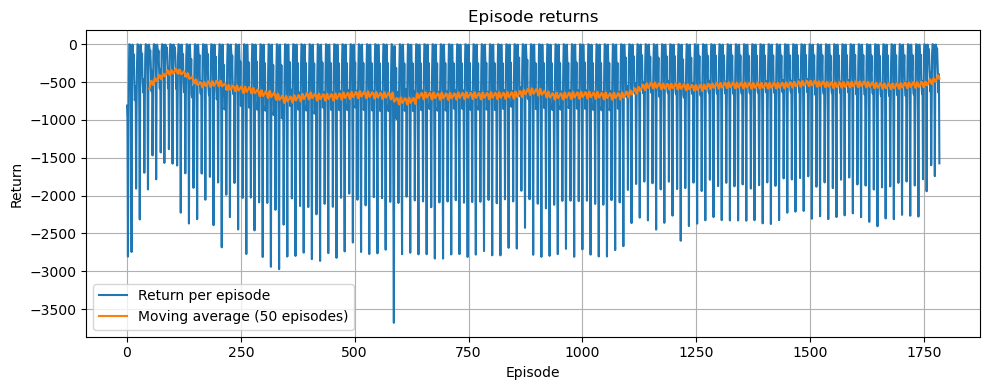

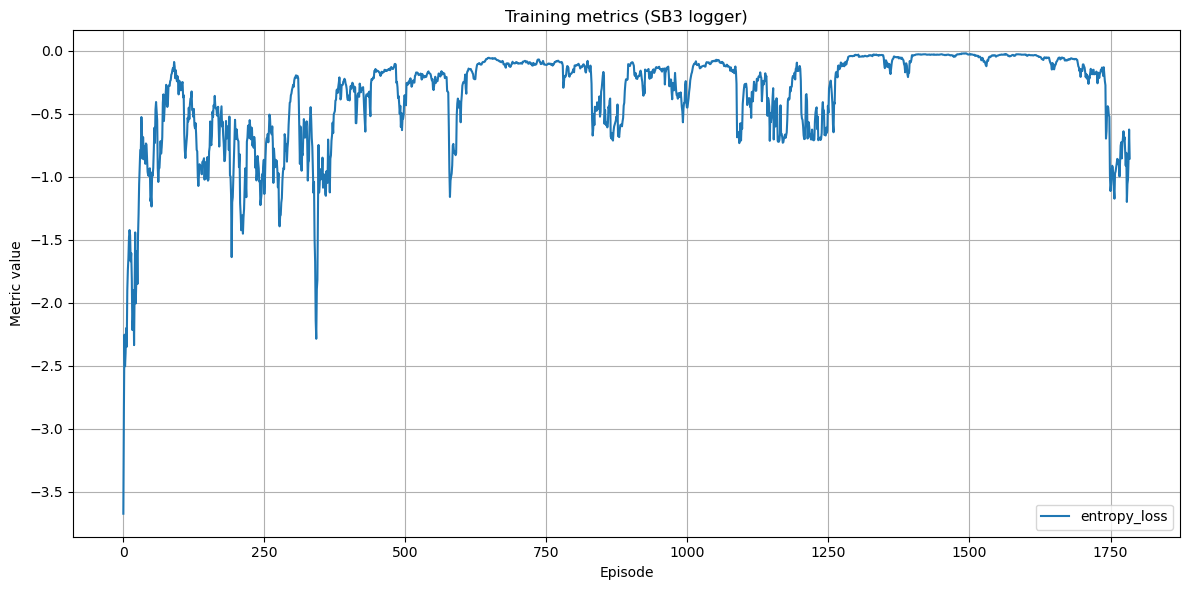

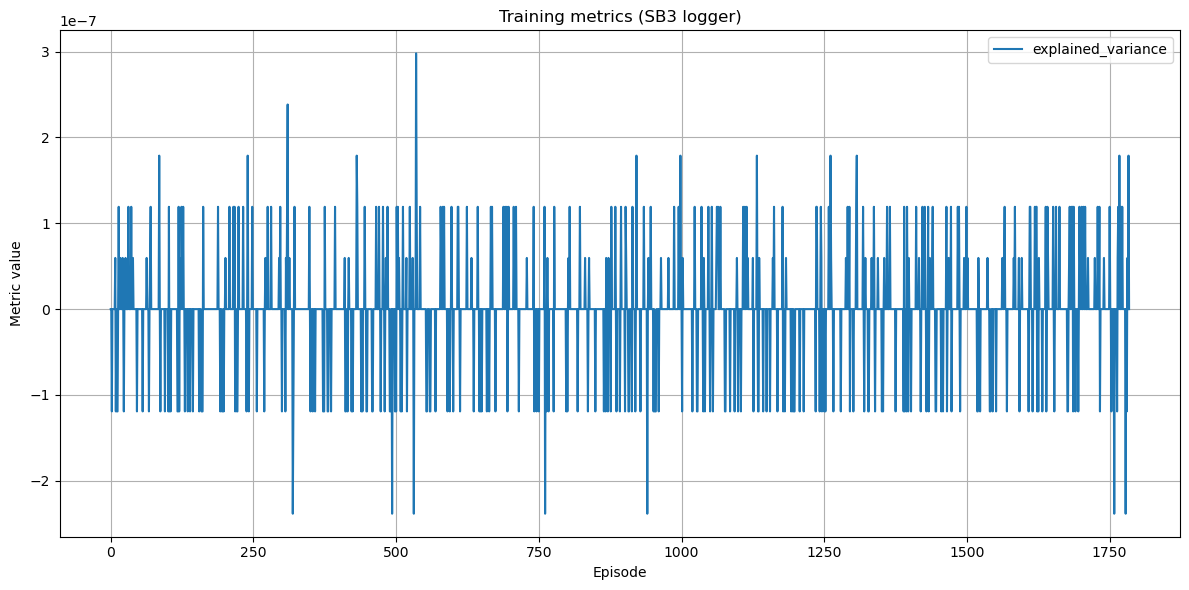

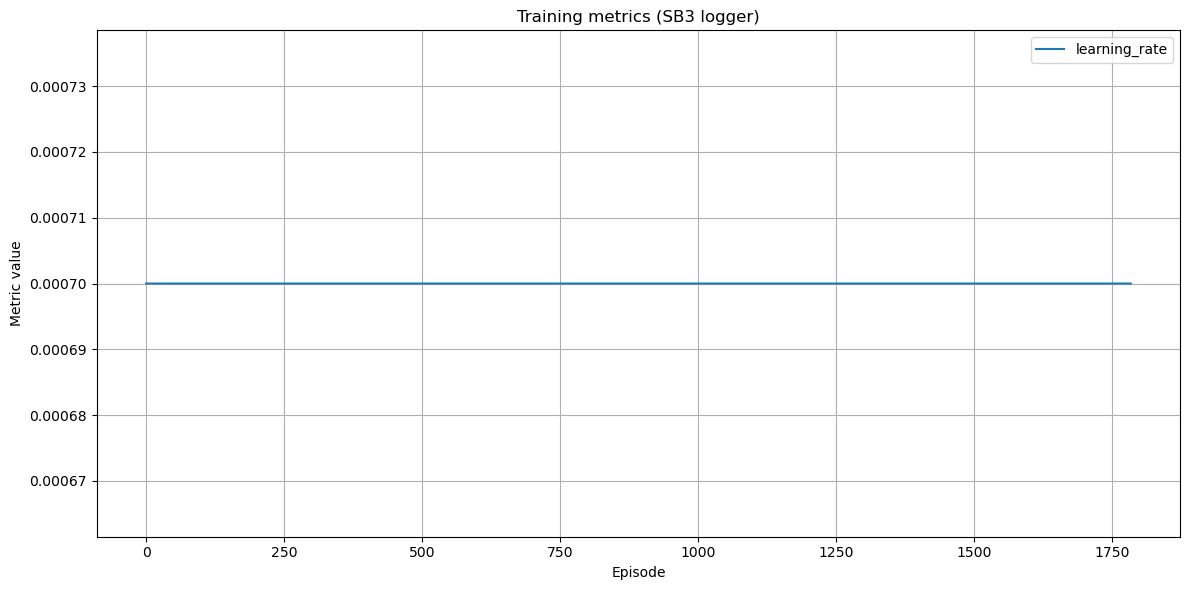

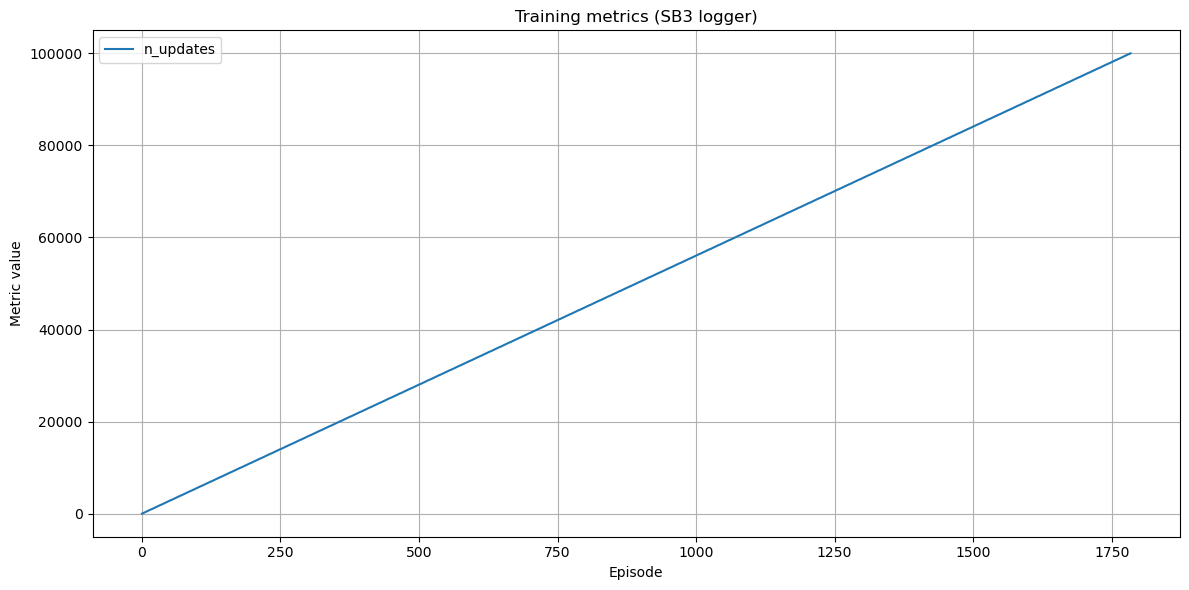

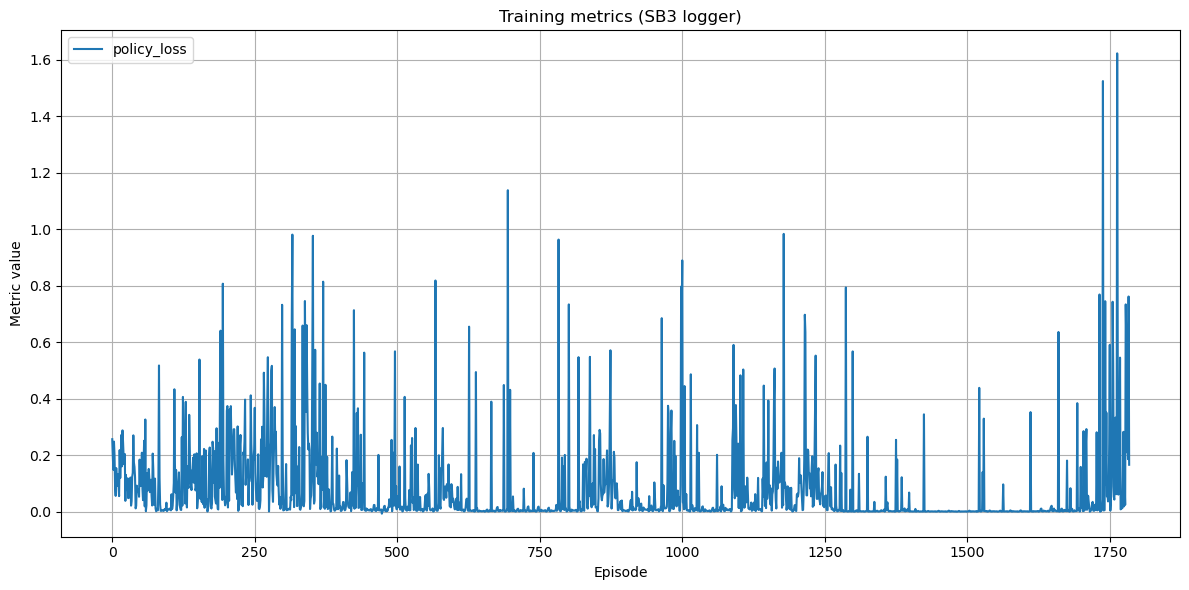

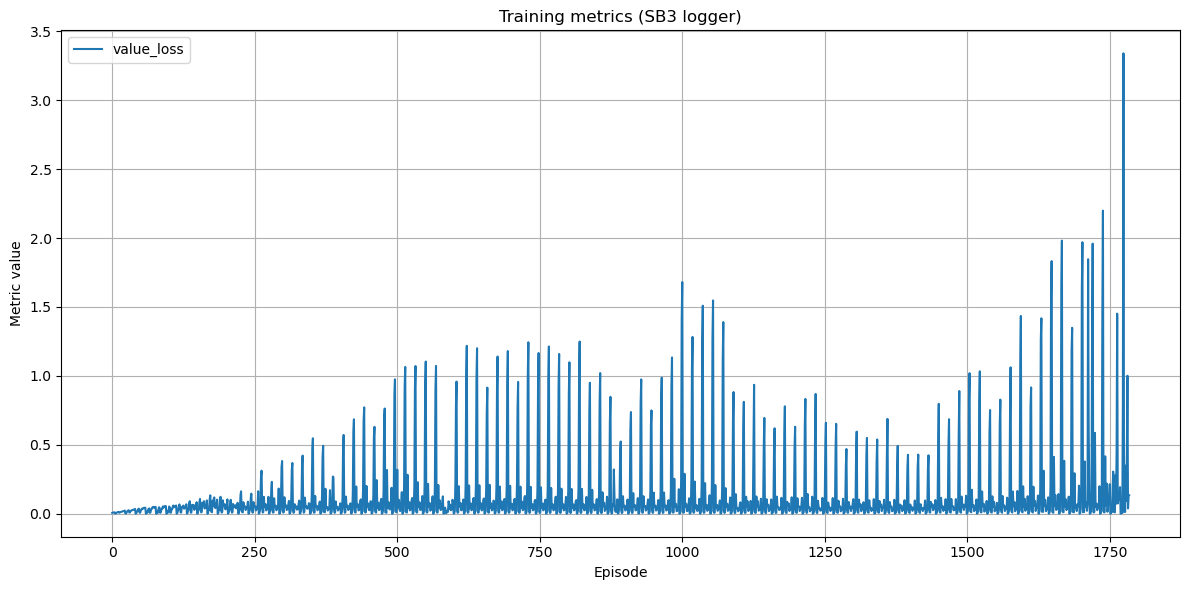

In [ ]:
plot_from_callback(metrics_cb, rolling_window=50)

In [ ]:
# Winter simulation period
PARAMS["fmu_start_time"] = 15 * 24 * 3600     # Jan 16
PARAMS["fmu_final_time"] = 50 * 24 * 3600     # Feb 19

# Create base FMI-MLC environment
base_env = fmi_gym(parameter=PARAMS)

# Wrap with SB3Wrapper
env = SB3Wrapper(base_env)

# Train the RL agent on winter period
model.set_env(env)
model.lr_schedule = lambda _: 1e-4 # adjust learning rate not to forget previous summer training

# Train the RL agent on winter period
metrics_cb = EpisodeStatsCallback(verbose=1)
progress_cb = TqdmProgressCallback(total_timesteps=total_timesteps)
callback = CallbackList([metrics_cb, progress_cb])

model.learn(
    total_timesteps=total_timesteps,
    callback=callback,
    progress_bar=False,  # DISATTIVA la barra interna SB3
)

plot_from_callback(metrics_cb, rolling_window=50)

In [ ]:
# Save the trained model
model.save("trained_a2c_model_fixed_reward")


print("✅ Model saved as 'trained_a2c_model_fixed_reward.zip'")

✅ Model saved as 'trained_a2c_model.zip'


In [ ]:
# --- CELL 2 ---
# Load the model and run predictions WITHOUT an environment

from stable_baselines3 import A2C
import numpy as np

# Load the saved model
model = A2C.load("trained_a2c_model_fixed_reward")
print("✅ Model loaded")

# Example observation: build it from your real observation dictionary
# Assuming you have:
obs_dict = {"Tair_z1": 25, "Tair_z2": 27, "Tair_z4": 26, "T_ext": 29, "DNI": 120, "DistrictHeating": 0, "DistrictCooling": 500, \
            "ShadeStatus_Zone1_Wall2": 0, "ShadeStatus_Zone1_Wall8": 0, "ShadeStatus_Zone1_Wall9": 0, "ShadeStatus_Zone2_Wall2": 0, "ShadeStatus_Zone2_wall3": 0, "ShadeStatus_Zone4_Wall2": 0}

# Convert obs_dict to a numpy array in the correct order
obs = np.array([obs_dict[n] for n in PARAMS["observation_names"]], dtype=np.float32)

# Predict action
action, _ = model.predict(obs, deterministic=True)
print("Predicted action:", action)

✅ Model loaded
Predicted action: [0 1 1 0 0 0]
